# Pytorch : Convolution Neural Network

- package that we use the most :
    - **torch** :contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. (eg. `tensor()`)
    - **torch.nn** : These are the basic building block for graphs, Provide Layer class extends `Module` ( eg.  `Conv2d()` )
    - **torch.nn.functional** : Nice to use activate function ( eg. `relu()` )
    - **torch.optim** : is a package implementing various optimization algorithms. Most commonly used methods are already supported, and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.
    - **numpy** : NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays.
    - **matplotlib** : Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(linewidth=120)

## Introduce Dataset :  Fashion MNIST
> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

![title](img/fashion-mnist-sprite.png)

### Classes
Index         | Label       |
--------------|-------------|
0             | T-shirt/top |
1             | Trouser     |
2             | Pullover    |
3             | Dress       |
4             | Coat        |
5             | Sandal      |
6             | Shirt       |
7             | Sneaker     |
8             | Bag         |
9             | Ankle boot  |

- **torchvision** :The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
- **torchvision.transforms** : Transforms are common image transformations. They can be chained together using Compose. Additionally, there is the torchvision.transforms.functional module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).


In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
data_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=10
)

In [4]:
batch = next(iter(data_loader))

In [5]:
images, labels = batch
images.shape

torch.Size([10, 1, 28, 28])

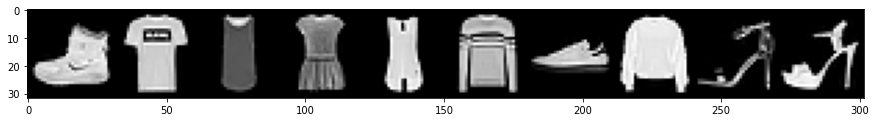

In [6]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap='gray') # 1,2 axis change

## Forward Computing without training
### Build CNN Model 

![title](img/cnn-model.jpeg)

- **__init__** : create layer that will be used define in constructor
- **forward** : define the sequence of order and operation between the layers.

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4* 4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer 
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        
        return t


- **torch.set_grad_enabled** : default is True: to set not trainable, can set gradient to false

In [8]:
torch.set_grad_enabled(False)

In [9]:
network = Network()

- pass 10 images into CNN model

In [10]:
preds = network(images) # batch, channel, H, W

In [15]:
print(preds.argmax(dim=1))
print(labels)
print(preds.argmax(dim=1).eq(labels))

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum()

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])
tensor([False, False, False, False, False, False, False, False, False, False])


In [16]:
get_num_correct(preds, labels)

tensor(0)

## Training Process
- 1.Get batch from the training set
- 2.Pass batch to network
- 3.Calculate the loss (difference between the predicted value and the true values)( **loss function** )
- 4.Calculate the gradient of the loss function w.r.t the network's weights ( **back propagation [gradient decent]** )
- 5.Update the weights using the gradients to reduce the loss ( **optimizer** )
- 6.Repeat steps 1-5 until one epoch is completed
- 7.Repeat steps 1-6 for as many epochs required to obtain the desired level of accuracy

In [17]:
torch.set_grad_enabled(True)

### Calcilating Loss

- Loss Function : to see difference between labels and predictions

![title](img/cross_entropy.png)

In [18]:
preds = network(images) # pass batch size 10 data into CNN
loss = F.cross_entropy(preds, labels) # calculate the loss. Loss Function : Cross Entropy
loss.item()

2.2650158405303955

### Calcilating the gradients

In [19]:
print(network.conv1.weight.grad)

None


In [20]:
loss.backward() # calculating the gradients

In [21]:
print(network.conv1.weight.grad)

tensor([[[[ 3.1444e-03,  4.1111e-03,  3.0864e-03,  3.4830e-03,  4.6057e-03],
          [ 2.3102e-03,  3.6116e-03,  3.5012e-03,  4.3221e-03,  4.5587e-03],
          [ 3.4459e-03,  3.5668e-03,  2.3901e-03,  2.5005e-03,  3.8264e-03],
          [ 2.3543e-03,  1.2262e-03,  2.0909e-03,  2.8675e-03,  3.0304e-03],
          [ 8.4693e-04,  1.8002e-03,  2.7249e-03,  1.8636e-03,  2.5106e-03]]],


        [[[ 1.4710e-05,  2.8930e-05,  8.9615e-06,  7.4844e-05,  2.7917e-05],
          [ 6.9032e-05,  9.2600e-05, -7.5457e-05, -6.3946e-05, -7.9654e-05],
          [-5.9368e-05, -1.4057e-04, -2.0626e-04, -1.6027e-04, -1.7164e-04],
          [ 3.4168e-07, -4.7775e-05, -1.0996e-04, -3.5899e-05,  1.0346e-04],
          [-1.2970e-05, -1.0238e-04, -8.5005e-05,  1.6476e-05,  1.0556e-04]]],


        [[[ 6.0504e-06,  3.3032e-04,  8.5228e-04,  5.9762e-04,  1.0880e-03],
          [ 1.1783e-03,  1.3783e-03,  1.6054e-03,  8.2604e-04,  1.6670e-03],
          [ 4.6574e-04,  6.5204e-04,  1.5223e-03,  1.9535e-03,  2.24

### update parameters strategy
- optimizer : SGD, Adam, ....
- learning rate : need to bwe tuning
#### we hope loss getting smaller

In [22]:
optimizer = optim.Adam(network.parameters(), lr=0.01)

- loss 1

In [23]:
loss.item()

2.2650158405303955

In [24]:
optimizer.step() # update

In [25]:
preds = network(images)

In [26]:
loss = F.cross_entropy(preds, labels)

- loss 2

In [27]:
loss.item()

2.180009365081787

In [28]:
get_num_correct(preds, labels)

tensor(3)

### Summary

In [29]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # 1.Get Batch
images, labels = batch

preds = network(images) # 2.Pass Batch
loss = F.cross_entropy(preds, labels) # 3.Calculate Loss
print('loss 1:', loss.item())

loss.backward() # 4.Calculate Gradients (baclpropagation)
optimizer.step() # 5.Update Weights


preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss 2:', loss.item())

loss 1: 2.3043198585510254
loss 2: 2.2807042598724365


## Training with all batches: A single epoch
- we take 600 step to update the weight

In [30]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in train_loader:
    images, labels = batch #1. Get Batch
    preds = network(images) # 2.Pass Batch
    loss = F.cross_entropy(preds, labels) # 3.Calculate Loss
    optimizer.zero_grad() # 因為 pytorch 會對 paramemter grad 做累加，所以我們將其歸零
    loss.backward() # 4.Calculate Gradients (baclpropagation)
    optimizer.step() # 5.Update Weights
    
    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

print("epoch:", 0, "total_correct:", total_correct, "total_loss:", total_loss)

epoch: 0 total_correct: tensor(47212) total_loss: 334.3945464491844


In [31]:
total_correct/len(train_set)

tensor(0.7869)

## training with multiple epochs (complete trainig loop)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

torch.set_printoptions(linewidth=120)

In [33]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [34]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4* 4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer 
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        
        return t


In [35]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

def get_num_correct(pred, labels):
    return pred.argmax(dim=1).eq(labels).sum()

for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images, labels = batch #1. Get Batch
        preds = network(images) # 2.Pass Batch
        loss = F.cross_entropy(preds, labels) # 3.Calculate Loss
        optimizer.zero_grad() # 因為 pytorch 會對 paramemter grad 做累加，所以我們將其歸零
        loss.backward() # 4.Calculate Gradients (baclpropagation)
        optimizer.step() # 5.Update Weights
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    print("epoch:", epoch, "total_correct:", total_correct, "total_loss:", total_loss)

epoch: 0 total_correct: tensor(48023) total_loss: 321.1980665922165
epoch: 1 total_correct: tensor(51548) total_loss: 228.4615113288164
epoch: 2 total_correct: tensor(52202) total_loss: 209.41304391622543
epoch: 3 total_correct: tensor(52517) total_loss: 201.5326947271824
epoch: 4 total_correct: tensor(52792) total_loss: 193.8949031829834


In [36]:
print(total_correct/len(train_set))

tensor(0.8799)


## show confusion matrix

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [44]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [46]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [48]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

Confusion matrix, without normalization
[[5735    1   78   47   14    1   90    1   33    0]
 [  37 5823   11  103   13    3    5    0    5    0]
 [ 125    1 4840   19  671    0  288    1   55    0]
 [ 399   13   28 5223  215    1  104    1   16    0]
 [  19    2  426  189 5075    0  240    1   48    0]
 [   3    1    2    0    1 5717    2  221   10   43]
 [1911    1  560   62  592    0 2756    0  118    0]
 [   0    0    0    0    0   16    0 5902    4   78]
 [  39    3   16   16   20    6   22    7 5871    0]
 [   8    1    0    0    0   26    0  276   10 5679]]


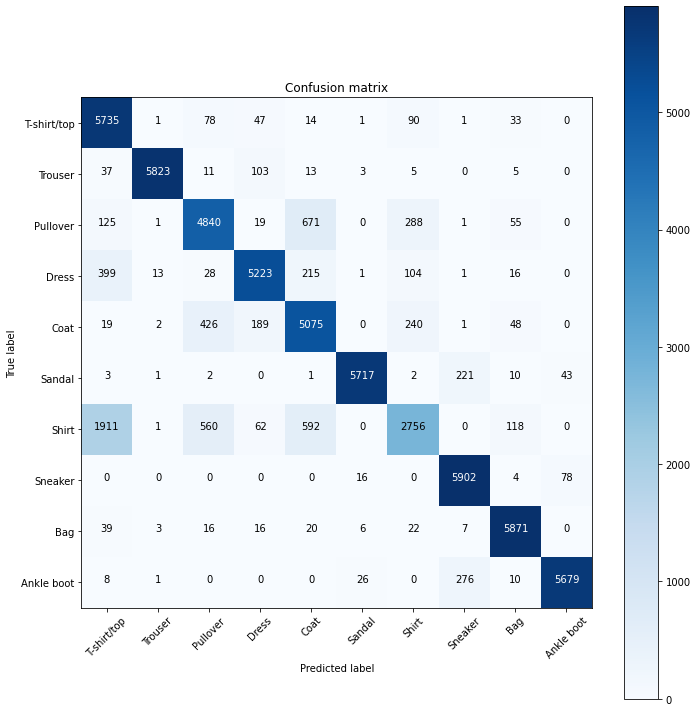

In [49]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_set.classes)